# Projet 8 : Déployez un modèle dans le cloud

Ce notebook a pour objectif de développer dans un environnement Big Data une première chaîne de traitement des données qui comprend le preprocessing et une étape de réduction de dimension. L'architecture Big Data doit permettre le passage à l’échelle avec des données massives.

Le notebook est organisé de la manière suivante :

* [**1. Prétraitement**](#1.-Prétraitement)
  * [**1.1 Connexion entre l'instance EC2 et le service S3 par le service IAM**](#1.1-Connexion-entre-l'instance-EC2-et-le-service-S3-par-le-service-IAM)
  * [**1.2 Configuration de Spark**](#1.2-Configuration-de-Spark)
  * [**1.3 Import des images**](#1.3-Import-des-images)
  * [**1.4 Extraction de features par le Transfer Learning**](#1.4-Extraction-de-features-par-le-Transfer-Learning)
* [**2. Réduction de dimension**](#2.-Réduction-de-dimension)
  * [**2.1 Prétraitement des données**](#2.1-Prétraitement-des-données)
    * [**2.1.1 Vectorisation**](#2.1.1-Vectorisation)
    * [**2.1.2 Standardisation**](#2.1.2-Standardisation)
  * [**2.2 Analyse en composantes principales (ACP)**](#2.2-Analyse-en-composantes-principales-(ACP))
  * [**2.3 Export et sauvegarde du résultat de la réduction de dimension en format csv sur S3**](#2.3-Export-et-sauvegarde-du-résultat-de-la-réduction-de-dimension-en-format-csv-sur-S3)
* [**Conclusion**](#Conclusion)

In [1]:
# Project 8: Deploy a model in the cloud
# Import libraries
import os
import logging
import warnings
import pandas as pd
%pylab inline
import seaborn as sns
import time

# I/O library
import io

# AWS S3 library
import boto3

# Import PySpark
import pyspark
import findspark
findspark.init()
findspark.find()


# Image processing libraries
from PIL import Image

# CNN (Convolutional Neural Network) Transfer learning libraries
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

# Pyspark library
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, udf, pandas_udf, PandasUDFType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StringIndexer, StandardScaler, PCA

# I/O library
from io import StringIO

# Disable WARNING, INFO, and DEBUG logging everywhere
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.WARNING)
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

Populating the interactive namespace from numpy and matplotlib


2022-04-29 10:43:41.850151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-29 10:43:41.850198: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(os.environ['PYSPARK_PYTHON'])

/home/ubuntu/anaconda3/bin/python


In [3]:
pyspark.__version__

'3.0.3'

# 1. Prétraitement

## 1.1 Connexion entre l'instance EC2 et le service S3 par le service IAM

- Les caractéristiques de l'instance EC2 sélectionnées :
  - Le modèle : Ubuntu Server 20.04 LTS ;
  - Le type : t3a large ;
  - La RAM : 8 Go ;
  - Capacité de stockage : 30 Go.
- Pour évaluer à l'avance les besoins, il est possible de réaliser des tests dans un environnement de développement (pour analyser les limites des systèmes) avec une distribution Linux gratuite (machine virtuelle Ubuntu pour les utilisateurs de Windows).
- La librairie (kit SDK AWS) "Boto3" permet de créer, de configurer et de gérer les services AWS. L'implémentation est basée sur l'exemple de la documentation de Boto 3 : https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3-example-creating-buckets.html
- L’architecture Big Data est composée de 3 services :
  - Le service S3 (Simple Storage Service) sert à stocker les données.
  - Le service EC2 (Elastic Compute Cloud) est le serveur qui permet de faire les calculs.
  - Le service IAM (Identity and Access Management) permet de gérer les utilisateurs.

In [4]:
# 1. Preprocessing
# 1.1 Connection between the EC2 instance and the S3 service
# via the IAM service
# AWS IAM user credentials
file = '/home/ubuntu/.aws/admin_user_credentials.csv'
credentials_df = pd.read_csv(file)
Acces_key_ID = credentials_df['Access key ID'].iloc[0]
Secret_access_key = credentials_df['Secret access key'].iloc[0]

# Names of the Bucket and the Oject
BUCKET_NAME = 'p8-cloud-bigdata-aws'
OBJECT_NAME = 'fruits-360-original-size/Training/'

# Creating the S3 client with IAM user credentials
s3_client = boto3.client(
    's3',
    aws_access_key_id=Acces_key_ID,
    aws_secret_access_key=Secret_access_key)

# Output the bucket names
response = s3_client.list_buckets()
print('\nExisting buckets:')
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')


Existing buckets:
  p8-cloud-bigdata-aws


## 1.2 Configuration de Spark

- Spark est un framework open source de calcul distribué (parallélisation des calculs) pour le traitement des données massives :
  - Le module Findspark permet de localiser Spark sur le serveur EC2.
  - Un SparkContext gère les propriétés globales de l'application Spark telles que le niveau de logging, le niveau de parallélisation par défaut, etc.
- Hadoop est un framework logiciel dédié au stockage et au traitement de larges volumes de données :
  - L’ordonnancement des traitements.
  - La localisation des fichiers.
  - La distribution de l’exécution sur les noeuds.
- PySpark est une interface pour Apache Spark en Python qui utilise scala par défaut.

In [5]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2 pyspark-shell'

In [6]:
# 1.2 Configuration of Spark
# Creating the SparkSession
spark = (SparkSession
         .builder.master('local[*]')
         .appName('p8_cloud_bigdata_aws')
         .config('spark.hadoop.fs.s3a.access.key', Acces_key_ID)
         .config('spark.hadoop.fs.s3a.secret.key', Secret_access_key) 
         .config('spark.hadoop.fs.s3a.impl',
                 'org.apache.hadoop.fs.s3a.S3AFileSystem') 
         .getOrCreate())

Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
:: loading settings :: url = jar:file:/home/ubuntu/spark-3.0.3-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
com.amazonaws#aws-java-sdk-pom added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e3caa537-ffa5-4a7a-82aa-4836e0f3390d;1.0
	confs: [default]
	found com.amazonaws#aws-java-sdk-pom;1.10.34 in central
	found org.apache.hadoop#hadoop-aws;2.7.2 in central
	found org.apache.hadoop#hadoop-common;2.7.2 in central
	found org.apache.hadoop#hadoop-annotations;2.7.2 in central
	found com.google.guava#guava;11.0.2 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found commons-cli#commons-cli;1.2 in central
	found org.apache.commons#commons-math3;3.1.1 in central
	found xmlenc#xmlenc;0.52 in central
	found commons-httpclient#commons-httpclient;3

22/04/29 10:44:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [7]:
# Instantiate the SparkContext
sc = spark.sparkContext
sc.setSystemProperty('com.amazonaws.services.s3.enableV4', 'true')
sc._jsc.hadoopConfiguration().set('fs.s3a.endpoint',
                                  's3.eu-west-3.amazonaws.com')

# Adjusting the logging level
sc.setLogLevel('ERROR')

In [8]:
# Enabling the arrow-based columnar data transfers
# Enabling for Conversion to/from Pandas
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [9]:
# Displaying the SparkSession information
spark

## 1.3 Import des images

Nous commençons par charger les images dans un Spark dataframe.

In [10]:
# 1.3 Loading the pictures
# Importing images in a Spark dataframe
start_time = time.time()
dataset_path = 's3a://' + BUCKET_NAME + '/' + OBJECT_NAME + '*'
images_df = spark.read.format(
    'binaryFile').option(
    'pathGlobFilter', '*.jpg').option(
    'recursiveFileLookup', 'true').load(dataset_path, inferschema=True)
images_df = images_df.select('path', 'length', 'content')
print(images_df.count())
images_df.printSchema()
images_df.show(10)
duration = time.time() - start_time
print("\nProcessing time: {:.1f} seconds".format(duration))

6231
root
 |-- path: string (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



+--------------------+------+--------------------+
|                path|length|             content|
+--------------------+------+--------------------+
|s3a://p8-cloud-bi...|125373|[FF D8 FF E0 00 1...|
|s3a://p8-cloud-bi...|125088|[FF D8 FF E0 00 1...|
|s3a://p8-cloud-bi...|124905|[FF D8 FF E0 00 1...|
|s3a://p8-cloud-bi...|124363|[FF D8 FF E0 00 1...|
|s3a://p8-cloud-bi...|124026|[FF D8 FF E0 00 1...|
|s3a://p8-cloud-bi...|123109|[FF D8 FF E0 00 1...|
|s3a://p8-cloud-bi...|123094|[FF D8 FF E0 00 1...|
|s3a://p8-cloud-bi...|122551|[FF D8 FF E0 00 1...|
|s3a://p8-cloud-bi...|122525|[FF D8 FF E0 00 1...|
|s3a://p8-cloud-bi...|122317|[FF D8 FF E0 00 1...|
+--------------------+------+--------------------+
only showing top 10 rows


Processing time: 65.9 seconds


Nous sélectionnons ensuite les colonnes pertinentes.

In [11]:
# Selecting the relevant columns of the dataframe
images_df = images_df.withColumn(
    'category', split(col('path'), '/').getItem(5))
images_df = images_df.select('path', 'content', 'category')
images_df.show(10)

+--------------------+--------------------+-----------+
|                path|             content|   category|
+--------------------+--------------------+-----------+
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|apple_hit_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|apple_hit_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|apple_hit_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|apple_hit_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|apple_hit_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|apple_hit_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|apple_hit_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|apple_hit_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|apple_hit_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|apple_hit_1|
+--------------------+--------------------+-----------+
only showing top 10 rows



Enfin, pour réduire la durée de traitement et donc les coûts de la construction de cette première version de l'architecture Big Data, nous sélectionnons un échantillon de 10 images.

Pour limiter les coûts, il est possible d'utiliser le Cost Management d'AWS :
- AWS budgets permet de définir un budget et de créer des alerts.
- Cost alert permet de recevoir des notifications par email en cas de dépassements du budget ou de l'usage gratuit.

In [12]:
# Selecting a subset of 10 images
start_time = time.time()
images_sdf = images_df.sample(withReplacement=False,
                              fraction=0.0012,
                              seed=0)
print(images_sdf.count())
images_sdf.printSchema()
images_sdf.show(10)
duration = time.time() - start_time
print("\nProcessing time: {:.1f} seconds".format(duration))

10
root
 |-- path: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- category: string (nullable = true)



+--------------------+--------------------+--------------------+
|                path|             content|            category|
+--------------------+--------------------+--------------------+
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|         apple_hit_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|          cucumber_3|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|         apple_red_3|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|apple_crimson_snow_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|apple_crimson_snow_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|         apple_red_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|    apple_braeburn_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|   apple_pink_lady_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|apple_granny_smith_1|
|s3a://p8-cloud-bi...|[FF D8 FF E0 00 1...|      apple_golden_2|
+--------------------+--------------------+--------------------+


Processing time: 247.0 seconds


## 1.4 Extraction de features par le Transfer Learning

Nous allons ensuite effectuer l'extraction de features par le Transfer Learning. On commence par charger un algorithme de type réseaux de neurones convolutifs (CNN). Il existe plusieurs modèles pré-entraînés (ResNet50, VGG16, EfficientNetB7, etc.), il faut donc sélectionner le modèle le plus adapté à la tâche à effectuer. Le modèle sélectionné est le ResNet50 pré-entraîné sur ImageNet.

In [13]:
# 1.4 Feature extraction using Transfer Learning
# Loading the pre-trained ResNet50 model
# Instantiate the base model with the pre-trained weights
model = ResNet50(
    # Whether to include the fully-connected layer
    # at the top of the network
    include_top=False,
    # Load the pre-trained weights on ImageNet
    weights='imagenet',
    # Optional Keras tensor to use as image input for the model
    input_tensor=None,
    # Optional shape tuple
    # only to be specified if include_top is False    
    input_shape=(224, 224, 3),
    # Optional pooling mode for feature extraction
    # when include_top is False
    pooling='max',
    # Optional number of classes to classify images into
    # only to be specified if include_top is True
    classes=1000)

# Verifying the removal of the top layer
model.summary()

2022-04-29 10:50:13.822944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-29 10:50:13.822989: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-29 10:50:13.823055: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-40-50): /proc/driver/nvidia/version does not exist
2022-04-29 10:50:13.823357: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

On repartit les poids du modèle pour être exécutés sur tous les noeuds.

In [14]:
# Broadcasting the weights of the model to be executed
# on all worker nodes
bc_model_weights = sc.broadcast(model.get_weights())

La méthode d'extraction de features utilisée est basée sur l'exemple de la documentation de Databricks :
https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html

In [15]:
# Functions
def load_model():
    '''This function loads the pre-trained ResNet50 model
    with the fully-connected layer removed
    and broadcasts the pre-trained weights.
    '''
    model = ResNet50(include_top=False,
                     weights='imagenet',
                     input_shape=(224, 224, 3),
                     pooling='max')
    model.set_weights(bc_model_weights.value)
    
    return model


def image_preprocessing(image):
    '''This function loads and returns a preprocessed picture.'''
    # Loading and resizing the picture
    image = Image.open(io.BytesIO(image)).resize([224, 224])
    
    # Converting the image pixels to a numpy array
    image = img_to_array(image)
    
    # Reshaping the input data
    # image = np.expand_dims(image, axis=0)

    # Preprocessing: normalising input data
    image = preprocess_input(image)
    
    return image


def feature_extractor(model, series_content):
    '''This function extracts features of a Pandas series
    of raw images using the Transfer Learning
    and returns a Pandas series of the features of images.
    '''
    # Image preprocessing
    input = np.stack(series_content.map(image_preprocessing))
    
    # Getting the features
    predictions = model.predict(input)
    
    # Flatten the features tensors to vectors
    # for easier storage in the Spark dataframe
    features = [p.flatten() for p in predictions]
    
    # Creating a Pandas series of image features
    features_series = pd.Series(features)
    return features_series


@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def apply_udf_featurizer(content):
    '''This function is a Scalar Iterator pandas UDF wrapping
    the feature_extractor. The decorator specifies that
    this returns a Spark DataFrame column of type ArrayType(FloatType).
    '''
    # Loading the model once
    model = load_model()
    
    # Applying the featurization function
    for series_content in content:
        yield feature_extractor(model, series_content)

Nous allons appliquer la fonction permettant d'extraire les features.

Le paramètre "numPartitions" de la méthode repartition() permet de choisir le nombre de partitions des données. Avec deux partitions, les processeurs (2 vCPU) sont correctement utilisés.

In [16]:
# Applying the distributed featurization to the dataframe of images
start_time = time.time()
numPartitions = 2
features_df = images_sdf.repartition(numPartitions).select(
    col('path'),
    col('category'),
    col('content'),
    apply_udf_featurizer('content').alias('features'))
features_df.printSchema()
features_df.show(10)
duration = time.time() - start_time
print("\nProcessing time: {:.1f} seconds".format(duration))

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



+--------------------+--------------------+--------------------+--------------------+
|                path|            category|             content|            features|
+--------------------+--------------------+--------------------+--------------------+
|s3a://p8-cloud-bi...|         apple_hit_1|[FF D8 FF E0 00 1...|[6.9625673, 9.492...|
|s3a://p8-cloud-bi...|          cucumber_3|[FF D8 FF E0 00 1...|[5.1304393, 4.882...|
|s3a://p8-cloud-bi...|         apple_red_3|[FF D8 FF E0 00 1...|[14.562844, 0.961...|
|s3a://p8-cloud-bi...|apple_crimson_snow_1|[FF D8 FF E0 00 1...|[5.323951, 5.5890...|
|s3a://p8-cloud-bi...|apple_crimson_snow_1|[FF D8 FF E0 00 1...|[3.8937764, 4.312...|
|s3a://p8-cloud-bi...|         apple_red_1|[FF D8 FF E0 00 1...|[7.1280622, 6.190...|
|s3a://p8-cloud-bi...|    apple_braeburn_1|[FF D8 FF E0 00 1...|[6.4206247, 4.809...|
|s3a://p8-cloud-bi...|   apple_pink_lady_1|[FF D8 FF E0 00 1...|[4.9558983, 3.461...|
|s3a://p8-cloud-bi...|apple_granny_smith_1|[FF D8 FF E

# 2. Réduction de dimension

## 2.1 Prétraitement des données

### 2.1.1 Vectorisation

Nous commençons par transformer les variables en vecteurs denses.

In [17]:
# 2. Dimension reduction
# 2.1 Data preprocessing
# 2.1.1 Vectorisation
# Creating the dense vectors
start_time = time.time()
udf_vectorizer = udf(lambda x: Vectors.dense(x), VectorUDT())
vec_features_df = features_df.select(
    col('path'),
    col('category'),
    col('content'),
    col('features'),
    udf_vectorizer('features').alias('vectorized_features'))
vec_features_df.printSchema()
vec_features_df.show(10)
duration = time.time() - start_time
print("\nProcessing time: {:.1f} seconds".format(duration))

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- vectorized_features: vector (nullable = true)



+--------------------+--------------------+--------------------+--------------------+--------------------+
|                path|            category|             content|            features| vectorized_features|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|s3a://p8-cloud-bi...|         apple_hit_1|[FF D8 FF E0 00 1...|[6.9625673, 9.492...|[6.96256732940673...|
|s3a://p8-cloud-bi...|          cucumber_3|[FF D8 FF E0 00 1...|[5.1304393, 4.882...|[5.13043928146362...|
|s3a://p8-cloud-bi...|         apple_red_3|[FF D8 FF E0 00 1...|[14.562844, 0.961...|[14.5628442764282...|
|s3a://p8-cloud-bi...|apple_crimson_snow_1|[FF D8 FF E0 00 1...|[5.323951, 5.5890...|[5.32395076751709...|
|s3a://p8-cloud-bi...|apple_crimson_snow_1|[FF D8 FF E0 00 1...|[3.8937764, 4.312...|[3.89377641677856...|
|s3a://p8-cloud-bi...|         apple_red_1|[FF D8 FF E0 00 1...|[7.1280622, 6.190...|[7.12806224822998...|
|s3a://p8-cloud-bi...|    apple_braeb

### 2.1.2 Standardisation

Ensuite, nous standardisons les données.

In [18]:
# 2.1.2 Standardisation
# Centering and scaling data
start_time = time.time()
scaler = StandardScaler(withMean=True,
                        withStd=True,
                        inputCol='vectorized_features',
                        outputCol='scaled_features')
scaler_model = scaler.fit(vec_features_df)
scaled_features_df = scaler_model.transform(
    vec_features_df).select(['path',
                             'category',
                             'content',
                             'features',
                             'scaled_features'])
scaled_features_df.printSchema()
scaled_features_df.show(10)
duration = time.time() - start_time
print("\nProcessing time: {:.1f} seconds".format(duration))

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- scaled_features: vector (nullable = true)



+--------------------+--------------------+--------------------+--------------------+--------------------+
|                path|            category|             content|            features|     scaled_features|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|s3a://p8-cloud-bi...|         apple_hit_1|[FF D8 FF E0 00 1...|[6.9625673, 9.492...|[0.21088032675988...|
|s3a://p8-cloud-bi...|          cucumber_3|[FF D8 FF E0 00 1...|[5.1304393, 4.882...|[-0.3771130775769...|
|s3a://p8-cloud-bi...|         apple_red_3|[FF D8 FF E0 00 1...|[14.562844, 0.961...|[2.65007267524165...|
|s3a://p8-cloud-bi...|apple_crimson_snow_1|[FF D8 FF E0 00 1...|[5.323951, 5.5890...|[-0.3150085333063...|
|s3a://p8-cloud-bi...|apple_crimson_snow_1|[FF D8 FF E0 00 1...|[3.8937764, 4.312...|[-0.7740010618198...|
|s3a://p8-cloud-bi...|         apple_red_1|[FF D8 FF E0 00 1...|[7.1280622, 6.190...|[0.26399338336559...|
|s3a://p8-cloud-bi...|    apple_braeb

## 2.2 Analyse en composantes principales (ACP)

Nous effectuons l'ACP. C'est une méthode de réduction de dimension linéaire qui favorise la structure globale des données et qui maximise la variance en minimisant l’erreur en distance euclidienne entre les données originales et la projection. L'ACP s'applique à des données denses et permet de créer des variables décorrélées entre elles, et de diminuer leurs dimensions, tout en gardant un pourcentage de variance expliquée élevé.

In [19]:
# 2.2 Principal component analysis (PCA)
# Performing the PCA
start_time = time.time()
n_comp = 9
pca = PCA(k=n_comp,
          inputCol='scaled_features',
          outputCol='reduced_features')
pca_model = pca.fit(scaled_features_df)
reduced_features_df = pca_model.transform(
    scaled_features_df).select(['path',
                                'category',
                                'content',
                                'features',
                                'reduced_features'])
reduced_features_df.printSchema()
reduced_features_df.show(10)
duration = time.time() - start_time
print("\nProcessing time: {:.1f} seconds".format(duration))

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- reduced_features: vector (nullable = true)



+--------------------+--------------------+--------------------+--------------------+--------------------+
|                path|            category|             content|            features|    reduced_features|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|s3a://p8-cloud-bi...|         apple_hit_1|[FF D8 FF E0 00 1...|[6.9625673, 9.492...|[-47.129795813981...|
|s3a://p8-cloud-bi...|          cucumber_3|[FF D8 FF E0 00 1...|[5.1304393, 4.882...|[-28.262829411201...|
|s3a://p8-cloud-bi...|         apple_red_3|[FF D8 FF E0 00 1...|[14.562844, 0.961...|[-7.7585348562106...|
|s3a://p8-cloud-bi...|apple_crimson_snow_1|[FF D8 FF E0 00 1...|[5.323951, 5.5890...|[21.1098552843159...|
|s3a://p8-cloud-bi...|apple_crimson_snow_1|[FF D8 FF E0 00 1...|[3.8937764, 4.312...|[21.1473300175267...|
|s3a://p8-cloud-bi...|         apple_red_1|[FF D8 FF E0 00 1...|[7.1280622, 6.190...|[6.80869224238575...|
|s3a://p8-cloud-bi...|    apple_braeb

Nous affichons le pourcentage de variance expliquée par chaque composante.

In [20]:
# Percentage of variance explained by each component
pca_model.explainedVariance

DenseVector([0.2425, 0.1964, 0.1418, 0.14, 0.1067, 0.0572, 0.0514, 0.0497, 0.0142])

Nous allons visualiser l'éboulis des valeurs propres.

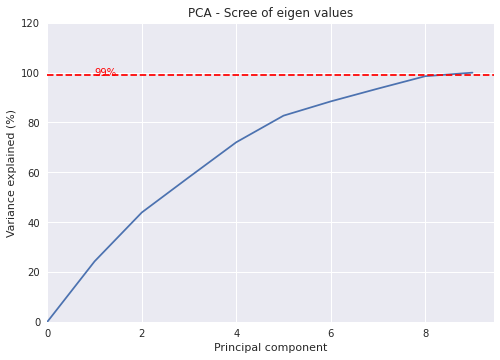

In [21]:
# Displaying the scree plot
eigen_val = pca_model.explainedVariance.cumsum()

# Setting up the figure
sns.lineplot(x=[i for i in range(n_comp + 1)], 
             y=np.insert(eigen_val, 0, 0) * 100)
plt.title('PCA - Scree of eigen values')
plt.xlabel('Principal component')
plt.ylabel('Variance explained (%)')
plt.ylim(0, 120)
plt.xlim(left=0)
plt.axhline(y=99, color='red', linestyle='--')
plt.text(1, 99, '99%', c='red')
plt.show()

Pour construire cette première version de l'architecture Big Data, on sélectionne 9 composantes principales (100% de la variance expliquée) pour la visualisation.
Le nombre de composantes principales dépend du pourcentage de variance expliquée souhaitée :
- Les 8 premières composantes principales permettent d'expliquer environ 99% de la variance totale.
- Les 6 premières composantes principales permettent d'expliquer environ 90% de la variance totale.
- Les 5 premières composantes principales permettent d'expliquer environ 85% de la variance totale.

Lorsque le volume des données augmente, il faudra adapter le nombre de composantes principales.

## 2.3 Export et sauvegarde du résultat de la réduction de dimension en format csv sur S3

On commence par créer les labels à partir des catégories des fruits.

In [22]:
# 2.3 Exporting and saving the result of the dimension reduction
# in csv format on S3
# Creating the labels
start_time = time.time()
indexer = StringIndexer(inputCol='category', outputCol='label')
indexer_model = indexer.fit(reduced_features_df)
preprocessed_df = indexer_model.transform(
    reduced_features_df).select(['path',
                                 'category',
                                 'label',
                                 'features',
                                 'reduced_features'])
preprocessed_df.show(10)
duration = time.time() - start_time
print("\nProcessing time: {:.1f} seconds".format(duration))

+--------------------+--------------------+-----+--------------------+--------------------+
|                path|            category|label|            features|    reduced_features|
+--------------------+--------------------+-----+--------------------+--------------------+
|s3a://p8-cloud-bi...|         apple_hit_1|  4.0|[6.9625673, 9.492...|[-47.129795813981...|
|s3a://p8-cloud-bi...|          cucumber_3|  8.0|[5.1304393, 4.882...|[-28.262829411201...|
|s3a://p8-cloud-bi...|         apple_red_3|  7.0|[14.562844, 0.961...|[-7.7585348562106...|
|s3a://p8-cloud-bi...|apple_crimson_snow_1|  0.0|[5.323951, 5.5890...|[21.1098552843159...|
|s3a://p8-cloud-bi...|apple_crimson_snow_1|  0.0|[3.8937764, 4.312...|[21.1473300175267...|
|s3a://p8-cloud-bi...|         apple_red_1|  6.0|[7.1280622, 6.190...|[6.80869224238575...|
|s3a://p8-cloud-bi...|    apple_braeburn_1|  1.0|[6.4206247, 4.809...|[12.8482530990671...|
|s3a://p8-cloud-bi...|   apple_pink_lady_1|  5.0|[4.9558983, 3.461...|[11.864156

On convertit ensuite le Spark dataframe en Pandas dataframe.

In [23]:
# Converting the Spark dataframe into a Pandas dataframe
dataset_df = preprocessed_df.toPandas()
dataset_df

,path,category,label,features,reduced_features
0,s3a://p8-cloud-bigdata-aws/fruits-360-original...,apple_hit_1,4.0,"[6.962567329406738, 9.492433547973633, 7.29555...","[-47.12979581398177, 26.06335348875705, 4.9630..."
1,s3a://p8-cloud-bigdata-aws/fruits-360-original...,cucumber_3,8.0,"[5.130439281463623, 4.882056713104248, 0.42877...","[-28.262829411201103, -48.70741978009874, -2.8..."
2,s3a://p8-cloud-bigdata-aws/fruits-360-original...,apple_red_3,7.0,"[14.562844276428223, 0.9616373777389526, 0.593...","[-7.758534856210661, 22.007037002936922, -23.5..."
3,s3a://p8-cloud-bigdata-aws/fruits-360-original...,apple_crimson_snow_1,0.0,"[5.32395076751709, 5.5890421867370605, 0.43348...","[21.109855284315902, -1.2047708354142452, -4.7..."
4,s3a://p8-cloud-bigdata-aws/fruits-360-original...,apple_crimson_snow_1,0.0,"[3.8937764167785645, 4.312593460083008, 0.7900...","[21.147330017526716, 0.4738377577635978, -5.03..."
5,s3a://p8-cloud-bigdata-aws/fruits-360-original...,apple_red_1,6.0,"[7.1280622482299805, 6.190267562866211, 3.6065...","[6.80869224238575, 5.1307971211400885, 43.0085..."
6,s3a://p8-cloud-bigdata-aws/fruits-360-original...,apple_braeburn_1,1.0,"[6.420624732971191, 4.809239387512207, 2.44468...","[12.848253099067142, 0.6652462867003023, 0.441..."
7,s3a://p8-cloud-bigdata-aws/fruits-360-original...,apple_pink_lady_1,5.0,"[4.955898284912109, 3.461568832397461, 0.0, 2....","[11.86415623217356, 1.393104194362233, -1.8056..."
8,s3a://p8-cloud-bigdata-aws/fruits-360-original...,apple_granny_smith_1,3.0,"[3.918422222137451, 5.247025489807129, 1.21618...","[10.008433313879934, -2.4242273608570355, -10...."
9,s3a://p8-cloud-bigdata-aws/fruits-360-original...,apple_golden_2,2.0,"[4.758269786834717, 11.997347831726074, 7.1577...","[-0.6355601079554737, -3.3969578752901755, -0...."


Enfin, on sauvegarde le Pandas dataframe sur S3 dans le compartiment 'p8-cloud-bigdata-aws'.

In [24]:
# Saving the Pandas dataframe on S3 into a bucket
csv_buffer = StringIO()
dataset_df.to_csv(csv_buffer, index=False)
s3_client.put_object(Body=csv_buffer.getvalue(),
                     Bucket=BUCKET_NAME,
                     Key='P8_03_pretraitement.csv')

{'ResponseMetadata': {'RequestId': 'Q21AMS8B2FR5R9EF',
  'HostId': 'yfGwHMpS5P9u+8jyHNpMKMHMBIfLTM2+SzOAjkn+qA+20OXod1LkQUMYwsHygt3vG1wt32UDiyU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'yfGwHMpS5P9u+8jyHNpMKMHMBIfLTM2+SzOAjkn+qA+20OXod1LkQUMYwsHygt3vG1wt32UDiyU=',
   'x-amz-request-id': 'Q21AMS8B2FR5R9EF',
   'date': 'Fri, 29 Apr 2022 11:17:02 GMT',
   'etag': '"739ac2ed4b6550f6285953e5369d09c0"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 1},
 'ETag': '"739ac2ed4b6550f6285953e5369d09c0"'}

# Conclusion

- L’architecture Big Data présentée permet d’effectuer le passage à l’échelle pour le traitement des données massives.
- Lors du passage à l'échelle, il faut adapter le nombre de composantes principales en fonction du volume des données et du pourcentage de variance expliquée souhaité.
- Pour résoudre les problématiques de complexité en mémoire et en temps de calcul, il faut :
  - Adapter les infrastructures (par exemple choisir une instance avec plus de RAM et plus de processeurs, utiliser un cluster de plusieurs serveurs ou machines, etc.).
  - Adapter les algorithmes à la large échelle ou Large Scale Learning (utiliser les approches stochastiques, installer TensorFlow-GPU ou utiliser TensorFlow-TPU, etc.).
- Il est possible de suivre les jobs Spark avec l’interface graphique Spark Web UI.